In [1]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split

In [17]:
eclipsing_binary_list = np.load("../dataset/light_curve_instance/eclipsing_binary/lc_eclipsing_binary.npy",
                                allow_pickle=True)
len(eclipsing_binary_list)

127339

In [2]:
demo_EB = eclipsing_binary_list[10000:20000]
np.save("../dataset/light_curve_instance/eclipsing_binary/demo_EB.npy", demo_EB)

NameError: name 'eclipsing_binary_list' is not defined

In [2]:
demo_EB = np.load("../dataset/light_curve_instance/eclipsing_binary/demo_EB.npy",
                                allow_pickle=True)

In [30]:
EA_list = [lc for lc in eclipsing_binary_list if lc.meta["variable_type"] == "EA"]
EB_list = [lc for lc in eclipsing_binary_list if lc.meta["variable_type"] == "EB"]
EW_list = [lc for lc in eclipsing_binary_list if lc.meta["variable_type"] == "EW"]
ELL_list = [lc for lc in eclipsing_binary_list if lc.meta["variable_type"] == "ELL"]

In [31]:
EA_period = [lc.meta["period"] for lc in EA_list]
EB_period = [lc.meta["period"] for lc in EB_list]
EW_period = [lc.meta["period"] for lc in EW_list]
ELL_period = [lc.meta["period"] for lc in ELL_list]

In [22]:
EA_period_idx = np.intersect1d(np.argwhere(
    np.percentile(EA_period, 20) < EA_period), np.argwhere(
    np.percentile(EA_period, 80) > EA_period))
EA_period = np.array(EA_period)[EA_period_idx]
min(EA_period), max(EA_period)

(0.9453148, 3.7057592)

In [23]:
import matplotlib.pyplot as plt
EB_period_idx = np.intersect1d(np.argwhere(
    np.percentile(EB_period, 20) < EB_period), np.argwhere(
    np.percentile(EB_period, 80) > EB_period))
EB_period = np.array(EB_period)[EB_period_idx]
min(EB_period), max(EB_period)
# plt.hist(EB_period, bins=100)
# plt.show()

(0.4732759, 1.4313431)

In [24]:
EW_period_idx = np.intersect1d(np.argwhere(
    np.percentile(EW_period, 20) < EW_period), np.argwhere(
    np.percentile(EW_period, 80) > EW_period))
EW_period = np.array(EW_period)[EW_period_idx]
min(EW_period), max(EW_period)

(0.2934709, 0.4530941)

In [3]:
from matplotlib import pyplot as plt

EA, EB, EW,ELL = None, None, None,None

for lc in demo_EB:
    if EA and EB and EW and ELL:
        break
    if lc.meta["class_probability"] > 0.8:
        if lc.meta["variable_type"] == "EA":
            EA = lc
        elif lc.meta["variable_type"] == "EB":
            EB = lc
        elif lc.meta["variable_type"] == "EW":
            EW = lc
        elif lc.meta["variable_type"] == "ELL":
            ELL = lc
    else:
        continue



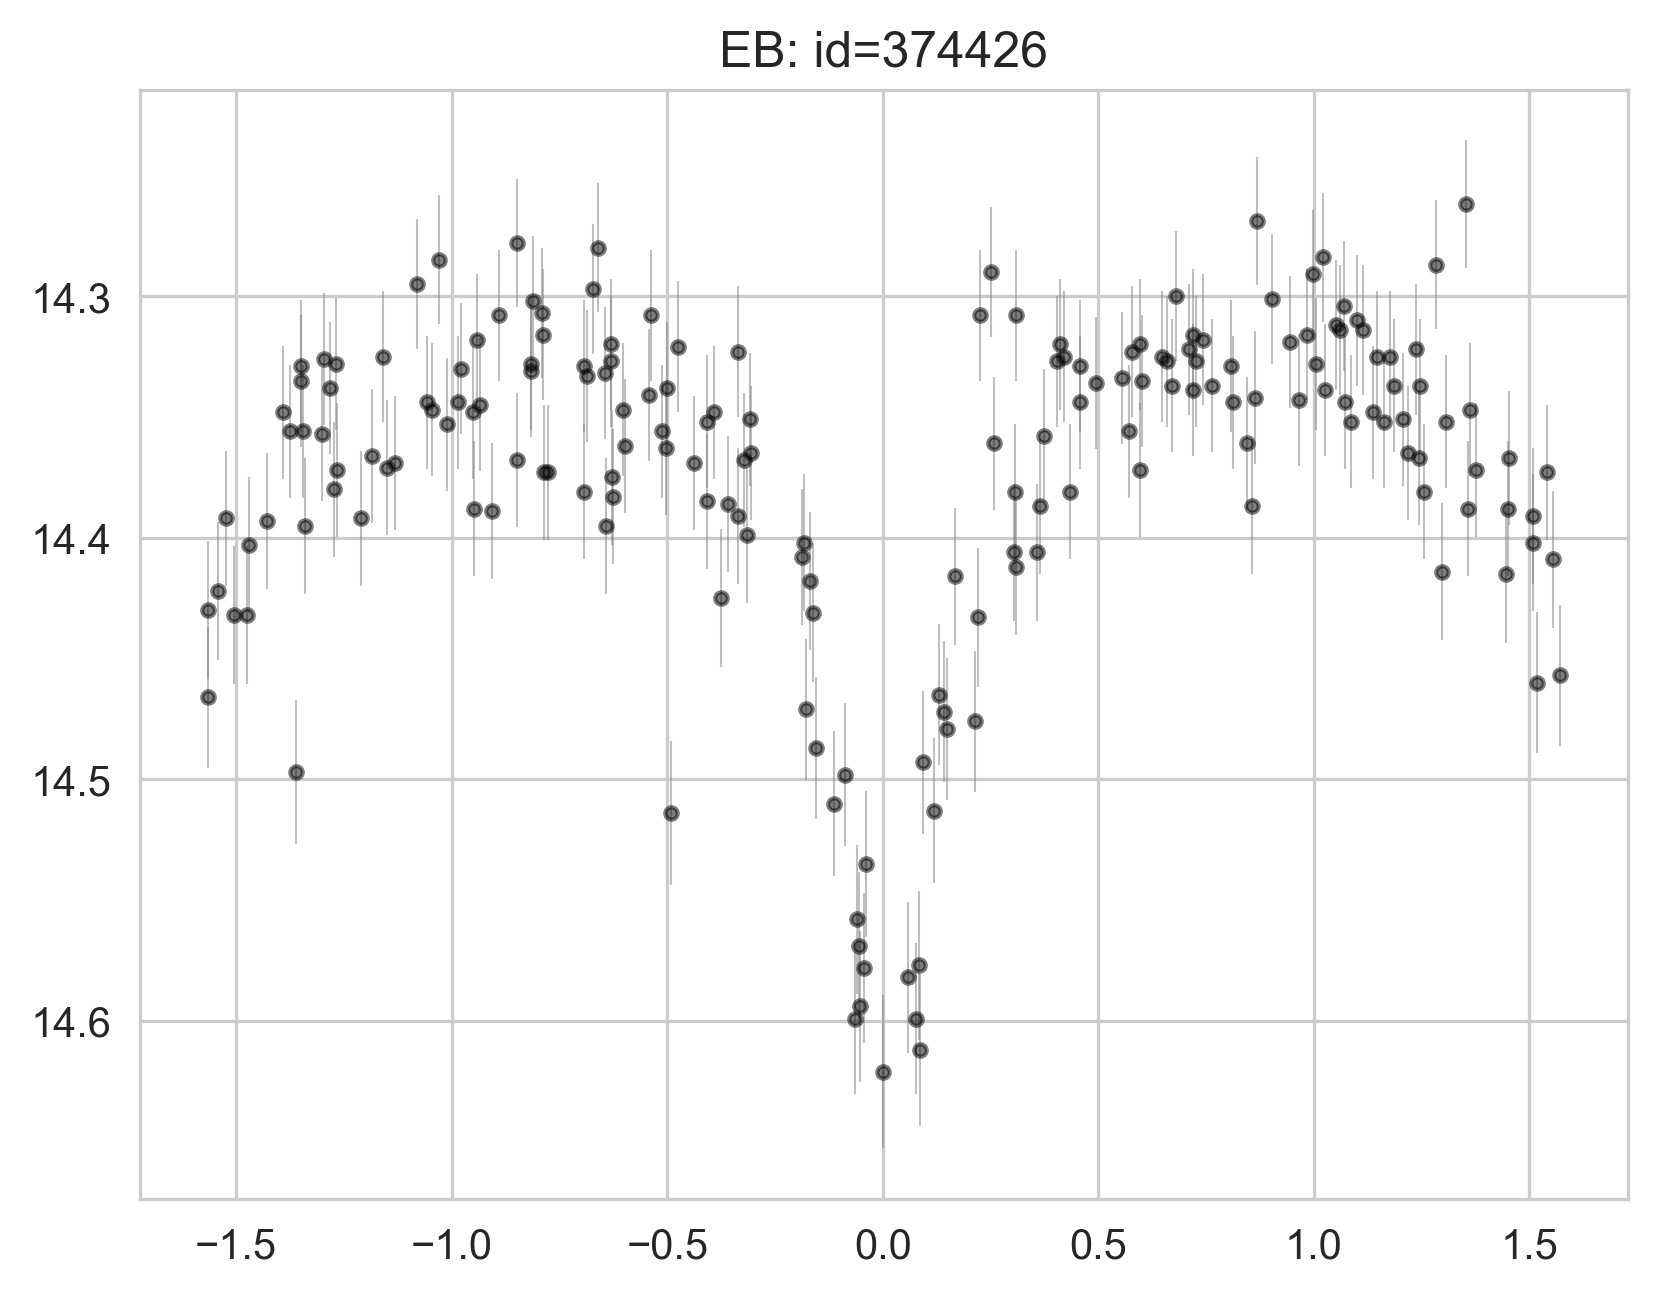

In [10]:
lc = EB
time = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value
period = lc.meta["period"]

fig,ax = plt.subplots(dpi=300)
plt.errorbar(time, flux, yerr=flux_err, fmt='.', ecolor='gray', color='black', elinewidth=0.5, capsize=0,alpha=0.5)
ax.invert_yaxis()
plt.title(lc.meta["variable_type"]+": id="+ lc.meta["source_id"])
plt.show()

In [11]:
from scipy.optimize import leastsq


def residuals(pars, x, y, order):
    # 通过傅里叶级数所拟合出来的值与真实值之间的误差
    return y - fourier_series(pars, x, order)


def fourier_series(pars, x, order):
    # 傅里叶级数 s = a_0 + \sum_{i=1}^{N} a_i*sin(2*pi*i*x)+b_i*cos(2*pi*i*x)
    sum = pars[0]
    for i in range(order):
        sum += pars[i * 2 + 1] * np.sin(2 * np.pi * (i + 1) * x) \
               + pars[i * 2 + 2] * np.cos(2 * np.pi * (i + 1) * x)
    return sum


order = 5
time = np.array(time)
period = float(period)
p0 = np.ones(order * 2 + 1)
date_period = (time % period) / period
p1, success = leastsq(residuals, p0, args=(date_period, flux, order), maxfev=20000)
p1

array([ 1.43762754e+01, -8.05442131e-03,  3.73698806e-02, -1.38918068e-03,
        6.65380006e-02, -2.57522039e-03,  1.98899471e-02,  1.02702057e-03,
        3.33280300e-02,  2.98805066e-03,  1.33036519e-02])

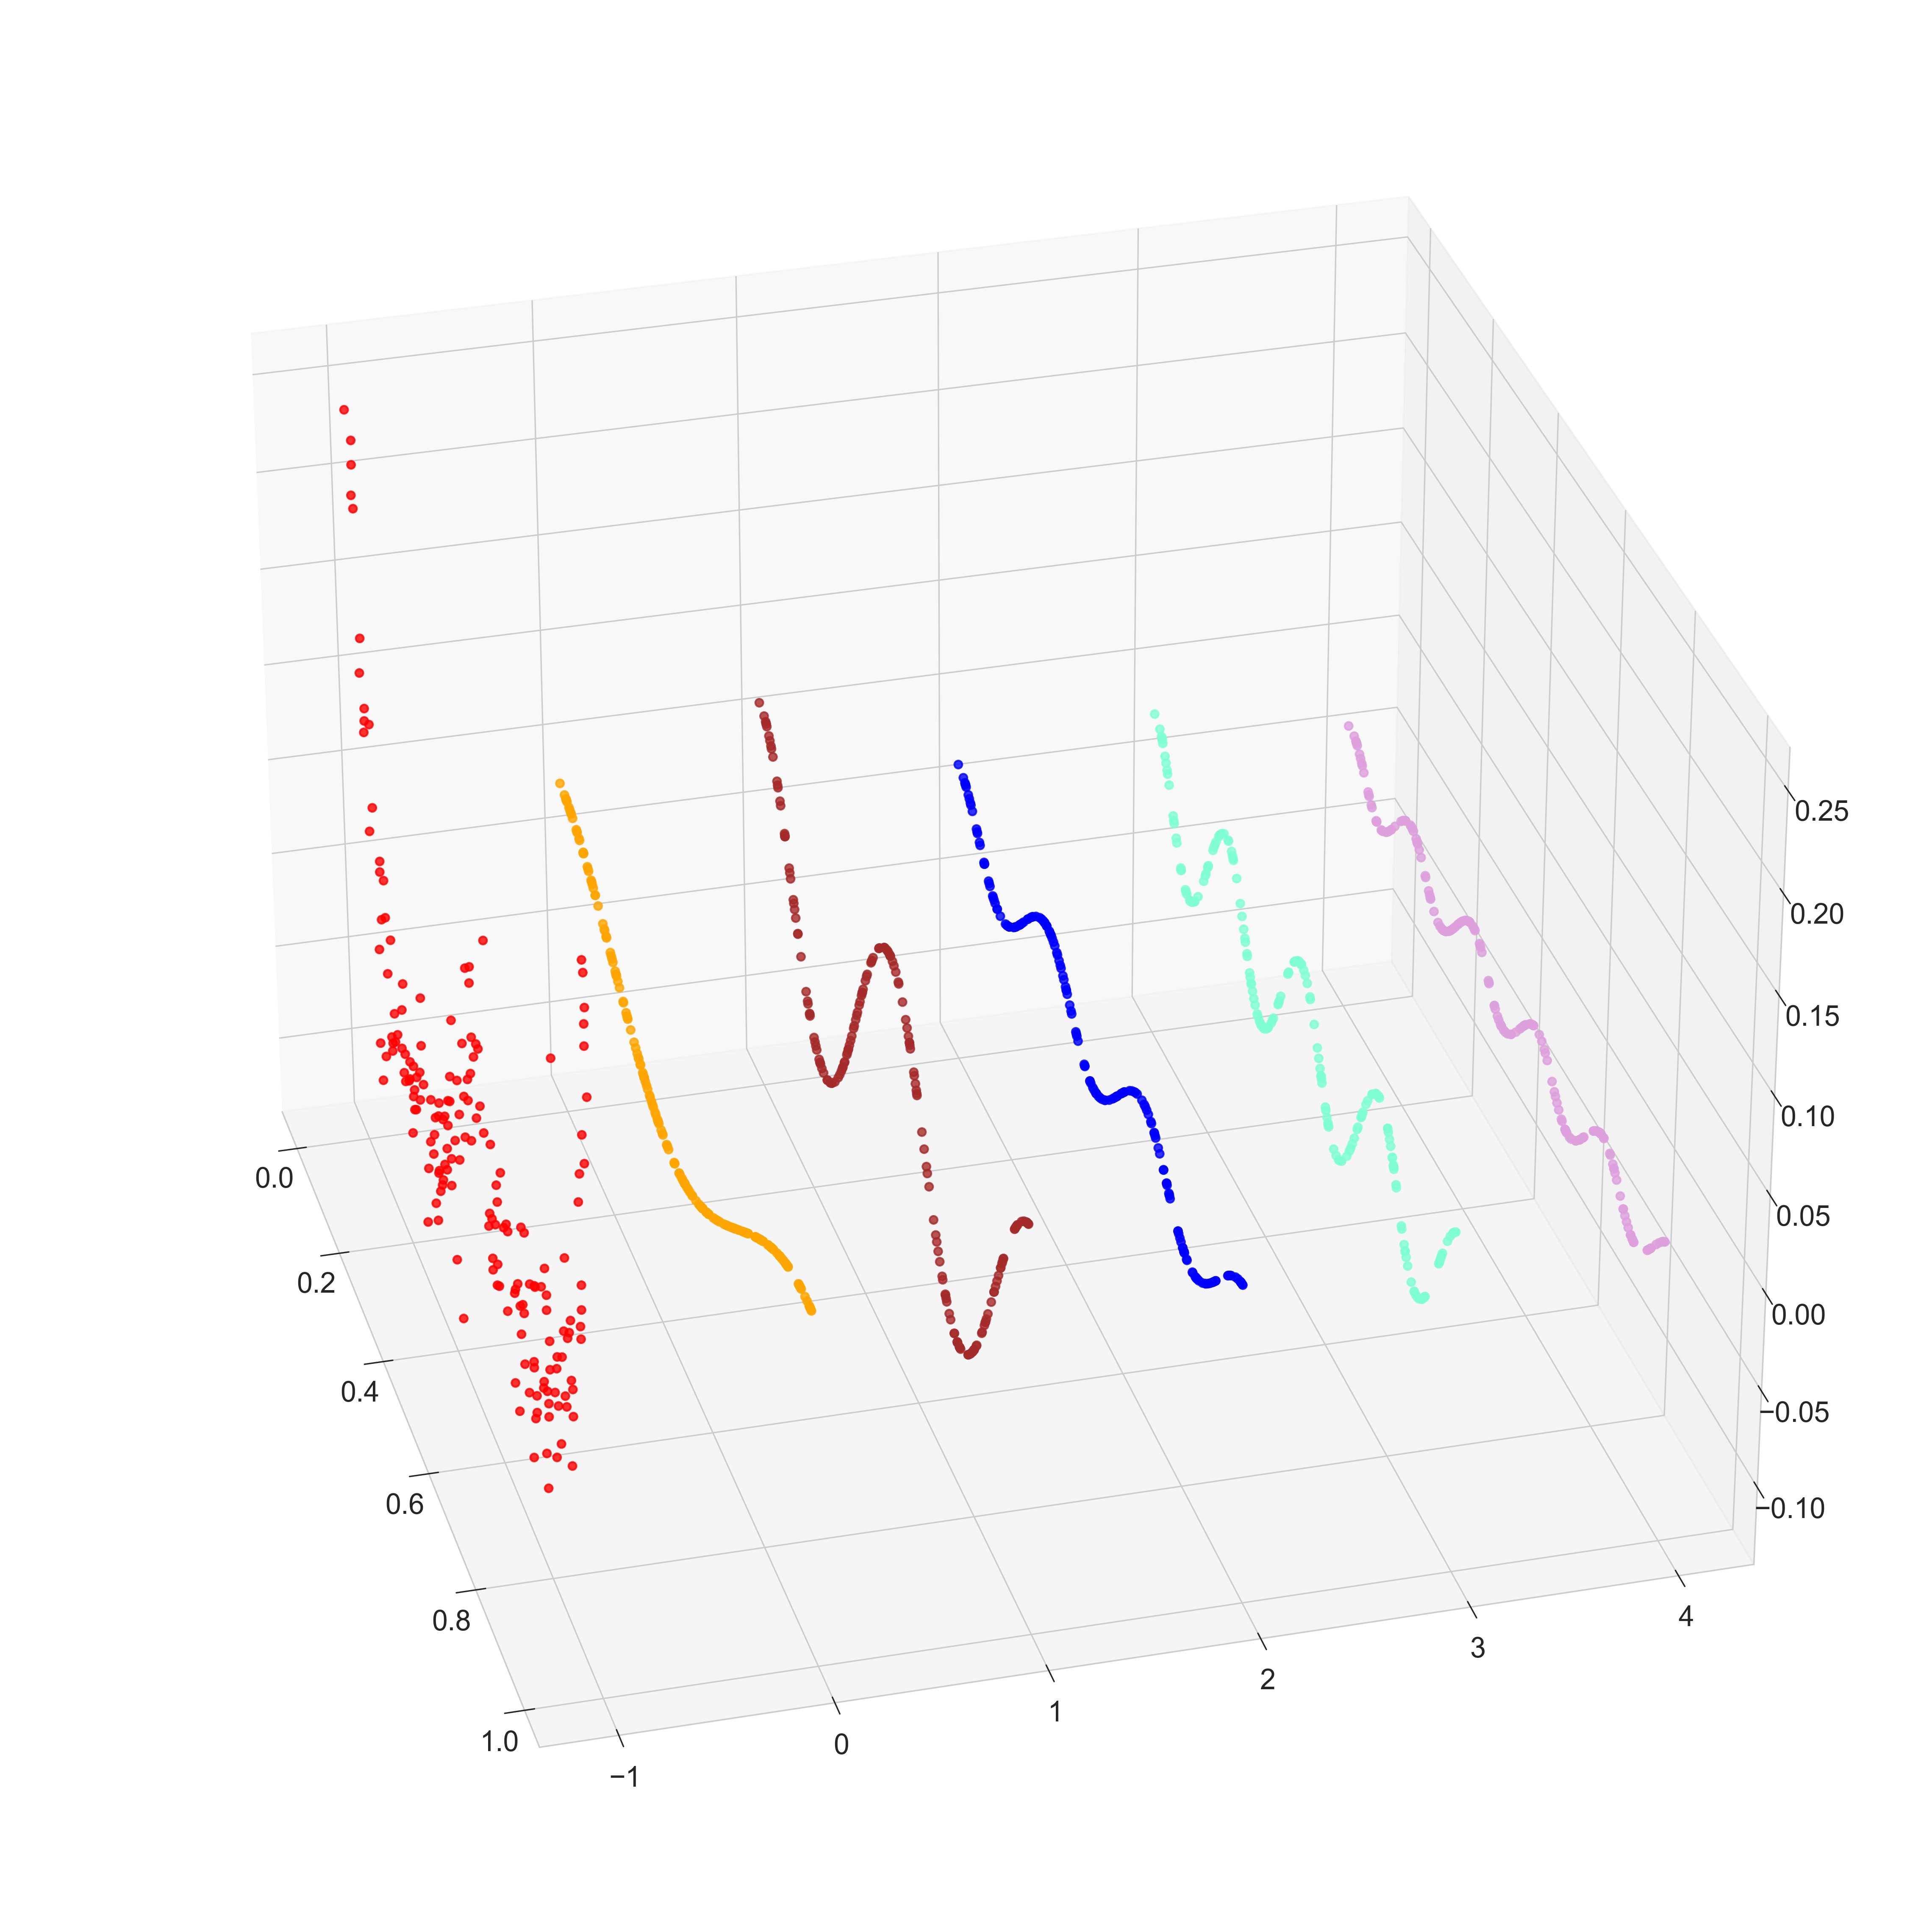

In [12]:
from mpl_toolkits.mplot3d import Axes3D

y_hat = p1[1] * np.sin(2 * np.pi * time) \
        + p1[2] * np.cos(2 * np.pi * time)

y_hats, t_hats, frequency_hats = [], [], []


def plot_fourier(t):
    for i in range(order):
        y_hat = p1[i * 2 + 1] * np.sin(2 * np.pi * (i + 1) * t) + p1[i * 2 + 2] * np.cos(2 * np.pi * (i + 1) * t)
        t_hat = t
        frequency_hat = [i for _ in range(len(t))]
        y_hats.extend(y_hat)
        t_hats.extend(t_hat)
        frequency_hats.extend(frequency_hat)


y_hats.extend(lc.flux.value - p1[0])
t_hats.extend(date_period)
frequency_hats.extend([-1 for _ in range(len(date_period))])




plot_fourier(date_period)
# plt.style.use('grayscale')
fig = plt.figure(figsize=(15, 15), dpi=300)
ax = Axes3D(fig, azim=-15)

fig.add_axes(ax)
map_color = {-1: 'red', 0: 'orange', 1: 'brown', 2: 'blue', 3: 'aquamarine', 4: 'plum'}
color = [map_color[i] for i in frequency_hats]
ax.scatter(t_hats, frequency_hats, y_hats, c=color, marker='o', alpha=0.8)
# ax.
# ax.yticks(fontproperties = 'Times New Roman', size = 18)
# ax.zticks(fontproperties = 'Times New Roman', size = 18)
ax.tick_params(labelsize=16)
# ax.set_xlabel("phase",fontproperties = 'Times New Roman', size = 18)
# ax.set_ylabel("frequency",fontproperties = 'Times New Roman', size = 18)
# ax.set_zlabel("flux",fontproperties = 'Times New Roman', size = 18)
# ax.set_title(lc.meta["source_id"])
plt.show()